In [1]:
import sys; sys.path.insert(0, '../')

# Boilerplate

In [2]:
# files
TRAINING_DIRECTORY = '../cnn/summary/'
EXTENSION = '.question'
N_TRAIN_FILES = 40000
N_TEST_FILES = 500

# tokenization
FILTERS = ''
PAD_CHAR = '@pad'
INPUT_END_CHAR = '@input-end'
TARGET_END_CHAR = '@target-end'
OOV_CHAR = '@unk'
PAD_TOKEN = 0
INPUT_END_TOKEN = 1
TARGET_END_TOKEN = 2
OOV_TOKEN = 3
MAX_VOCAB_SIZE = 20000

# MODEL_PARAMS
DECODER_INPUT_LEN = 180
DECODER_TARGET_LEN = 20
DECODER_TOTAL_LEN = DECODER_INPUT_LEN + DECODER_TARGET_LEN

# Read in files

In [3]:
import glob

In [4]:
FILES = glob.glob('%s/*%s' % (TRAINING_DIRECTORY, EXTENSION))
print(len(FILES))
FILES

380298


['../cnn/summary/239c17682016c0c244cdf46200c5f740c8a2c9db.question',
 '../cnn/summary/65c7b28e3ba0dacc5a85ab3ea1c9a635744bdf83.question',
 '../cnn/summary/dc65fd491d2ac61c83037e5c1338cf6de19f95ee.question',
 '../cnn/summary/603b08f191ac8bf06df441619dd912f446179065.question',
 '../cnn/summary/0b3c640ebc44567eb3beb8b8297638d7090e8384.question',
 '../cnn/summary/a3c5386bc005ef369b70267a5b4248b37052b64a.question',
 '../cnn/summary/4dfd23aa3de5205cfe91b091b5365994105d29ba.question',
 '../cnn/summary/36b0c8f1069460e5d997ad66c4ebff1c350c5000.question',
 '../cnn/summary/18062cf32b6e91bbfa45e8645317499d417e2d87.question',
 '../cnn/summary/b01d1b7f5bc30e17d727de4d8d85245b8ff2ffd0.question',
 '../cnn/summary/530c4400a0a83900c2810e2795607af94a2447a5.question',
 '../cnn/summary/9f17668a9cd8170fdad9788ed64e489e468cf9c3.question',
 '../cnn/summary/3eb19c15e3b126ef702183f031e6bedfd8276ed9.question',
 '../cnn/summary/198bf4f7ed30c58ad769029dc18f28c843172ae3.question',
 '../cnn/summary/20ba1ddd872afe8f1

In [5]:
TRAIN_FILES = FILES[:N_TRAIN_FILES]
TEST_FILES = FILES[N_TRAIN_FILES:N_TRAIN_FILES+N_TEST_FILES]

# Define batch generator

In [6]:
import random
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from data import BaseBatchGenerator

class SummaryBatchGenerator(BaseBatchGenerator):
    def __init__(self, tokenizer, num_words, decoder_input_len,
                 decoder_target_len, input_end_token, target_end_token,
                 pad_token):
        self.tokenizer = tokenizer
        self.num_words = num_words
        self.decoder_input_len = decoder_input_len
        self.decoder_target_len = decoder_target_len
        self.sentence_len = self.decoder_input_len + self.decoder_target_len
        self.input_end_token = input_end_token
        self.target_end_token = target_end_token
        self.pad_token = pad_token

    def generate_batches(self, steps, batch_size, n_batches):
        for i in range(n_batches):
            start, stop = i*batch_size, (i+1)*batch_size
            batch_steps = steps[start:stop]
            encoder_steps, decoder_steps = zip(*batch_steps)
            x1 = np.array(encoder_steps)
            x2 = np.array(decoder_steps)
            # offset target from decoder input
            X = [x1, x2[:,:-1]]
            y = x2[:,1:]
            yield X, y

    def generate_steps(self, item):
        training_example = self.process_file(item)
        if len(training_example.target_tokens) > self.decoder_target_len:
            return []
        encoder_tokens = training_example.input_tokens[:self.sentence_len]
        decoder_tokens = training_example.input_tokens[:self.decoder_input_len] \
                       + [self.input_end_token] \
                       + training_example.target_tokens \
                       + [self.target_end_token]
        example = self.pad(encoder_tokens), self.pad(decoder_tokens, prepend=True)
        return [example]

    def process_file(self, file):
        input_text, target_text = self.read_file(file)
        input_tokens = self.tokenizer([input_text])[0]
        target_tokens = self.tokenizer([target_text])[0]
        training_example = TrainingExample(file, input_text, target_text,
                                           input_tokens, target_tokens)
        return training_example

    @staticmethod
    def read_file(file):
        with open(file) as f:
            context, target = f.read().split('\t')
        return context, target
    
    def pad(self, tokens, prepend=False):
        # add 1 to sentence_len since we shift output one step forward to prevent
        # model from attending to future time steps
        tokens = pad_sequences(
            [tokens], maxlen=self.sentence_len, padding='post',
            truncating='post', value=self.pad_token)
        if prepend:
            tokens = pad_sequences(
                [tokens[0]], maxlen=self.sentence_len+1, padding='pre',
                value=self.pad_token)
        return tokens[0]

class TrainingExample:
    def __init__(self, item, input_text, target_text, input_tokens,
                 target_tokens):
        self.item = item
        self.input_text = input_text
        self.target_text = target_text
        self.input_tokens = input_tokens
        self.target_tokens = target_tokens

/home/dante/venvs/default/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Initialize Tokenizer

In [7]:
from tokenization import Tokenizer

In [8]:
tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    filters=FILTERS,
    oov_token=OOV_CHAR)

In [9]:
text_gen = (text for f in TRAIN_FILES+TEST_FILES for text in SummaryBatchGenerator.read_file(f))

In [10]:
%%time
tokenizer.fit_on_texts(text_gen)

CPU times: user 9.16 s, sys: 80 ms, total: 9.24 s
Wall time: 9.25 s


In [11]:
print('TOKENIZER.num_words', tokenizer.num_words)
print('len(TOKENIZER.word_index)', len(tokenizer.word_index))
tokenizer.word_index

TOKENIZER.num_words 20000
len(TOKENIZER.word_index) 65190


{'chimerix': 57208,
 'abilities': 7661,
 '673': 51640,
 'nightwatchman': 41492,
 '8/462': 56292,
 'toughly': 64943,
 'neck': 3797,
 'brooding': 29416,
 'troika': 20653,
 'crooning': 30885,
 'summonses': 38404,
 'perched': 11200,
 'route': 2539,
 'upcyclers': 54394,
 'disbursement': 39075,
 'offficial': 58631,
 '283': 23659,
 'helmand': 52322,
 'intensivist': 57663,
 'sartorial': 21719,
 'bleza21@gmail.com': 55914,
 '1:31.195': 62600,
 'synch': 25297,
 'preamble': 42377,
 'scanned': 17154,
 'sprucing': 61323,
 'circles': 6284,
 '3,863': 51455,
 'touching': 6528,
 'ingenuous': 45071,
 'gradually': 5428,
 'slopes': 10334,
 'depressurize': 43011,
 'collaborative': 10999,
 'crypto': 52064,
 'sunblock': 33359,
 'windfall': 15192,
 'vamp': 49546,
 '1,440': 28462,
 'reinterred': 31588,
 '8117': 58926,
 'forty': 7620,
 'seaweed': 26975,
 'co-president': 24914,
 'refocus': 17068,
 'picture': 1464,
 '36.1': 46613,
 'firebombing': 34481,
 'middleman': 27092,
 'e2': 52272,
 '–': 38565,
 'guardiola'

In [12]:
index_to_word = {v: k for k, v in tokenizer.word_index.items()}
index_to_word[PAD_TOKEN] = PAD_CHAR
index_to_word[INPUT_END_TOKEN] = INPUT_END_CHAR
index_to_word[TARGET_END_TOKEN] = TARGET_END_CHAR

In [13]:
sorted(index_to_word.items(), key=lambda x: x[0])

[(0, '@pad'),
 (1, '@input-end'),
 (2, '@target-end'),
 (3, '@unk'),
 (4, 'the'),
 (5, ','),
 (6, '.'),
 (7, 'to'),
 (8, '"'),
 (9, 'of'),
 (10, 'and'),
 (11, 'a'),
 (12, 'in'),
 (13, "'s"),
 (14, 'that'),
 (15, 'for'),
 (16, 'is'),
 (17, '-'),
 (18, 'on'),
 (19, 'it'),
 (20, 'said'),
 (21, 'was'),
 (22, 'he'),
 (23, 'with'),
 (24, 'as'),
 (25, 'i'),
 (26, 'his'),
 (27, '@entity1'),
 (28, '--'),
 (29, 'at'),
 (30, 'have'),
 (31, 'from'),
 (32, 'but'),
 (33, 'are'),
 (34, 'be'),
 (35, 'has'),
 (36, 'by'),
 (37, 'this'),
 (38, 'not'),
 (39, '@entity2'),
 (40, 'an'),
 (41, 'we'),
 (42, 'they'),
 (43, '@entity0'),
 (44, '@entity3'),
 (45, 'who'),
 (46, '@entity4'),
 (47, 'will'),
 (48, ')'),
 (49, '('),
 (50, "n't"),
 (51, 'you'),
 (52, ':'),
 (53, 'were'),
 (54, 'their'),
 (55, 'had'),
 (56, '@entity5'),
 (57, 'she'),
 (58, 'been'),
 (59, 'about'),
 (60, 'one'),
 (61, 'after'),
 (62, 'more'),
 (63, '@entity6'),
 (64, 'her'),
 (65, 'or'),
 (66, 'there'),
 (67, 'when'),
 (68, 'people'),
 (6

In [14]:
tokenizer.num_words = min(len(tokenizer.word_index)+1, tokenizer.num_words)
NUM_WORDS = tokenizer.num_words

In [15]:
TOKENIZER = tokenizer.texts_to_sequences

# Take a look at batches

In [16]:
batch_gen = SummaryBatchGenerator(
    tokenizer=TOKENIZER,
    num_words=NUM_WORDS,
    decoder_input_len=DECODER_INPUT_LEN,
    decoder_target_len=DECODER_TARGET_LEN,
    input_end_token=INPUT_END_TOKEN,
    target_end_token=TARGET_END_TOKEN,
    pad_token=PAD_TOKEN
).generate_forever(TRAIN_FILES, batch_size=32)

In [17]:
X, y = next(batch_gen)
x1, x2 = X

In [18]:
x1.shape, x2.shape, y.shape

((32, 200), (32, 200), (32, 200))

In [19]:
X

[array([[   49,    43,    48, ...,    59,    14,     5],
        [   49,    43,    48, ...,    57,  1250,   724],
        [   49,    43,    48, ...,  1098,   534,    82],
        ...,
        [   49,    43,    48, ...,    98,    27, 10624],
        [   49,    43,    48, ...,     0,     0,     0],
        [   49,    43,    48, ...,   152,    17,    76]], dtype=int32),
 array([[   0,   49,   43, ...,    0,    0,    0],
        [   0,   49,   43, ...,    0,    0,    0],
        [   0,   49,   43, ...,    0,    0,    0],
        ...,
        [   0,   49,   43, ..., 2125,   27,    2],
        [   0,   49,   43, ...,    0,    0,    0],
        [   0,   49,   43, ...,    0,    0,    0]], dtype=int32)]

In [20]:
y

array([[49, 43, 48, ...,  0,  0,  0],
       [49, 43, 48, ...,  0,  0,  0],
       [49, 43, 48, ...,  0,  0,  0],
       ...,
       [49, 43, 48, ..., 27,  2,  0],
       [49, 43, 48, ...,  0,  0,  0],
       [49, 43, 48, ...,  0,  0,  0]], dtype=int32)

In [21]:
def view_training_examples(x1, x2, y):
    print(' '.join([index_to_word[i] for i in x1]))
    print('\n')
    print(' '.join([index_to_word[i] for i in x2]))
    print('\n')
    print(' '.join([index_to_word[i] for i in y]))

In [22]:
np.where(x2[7] == 1), np.where(y[7] == 1)

((array([181]),), (array([180]),))

In [23]:
examples = zip(x1, x2, y)

In [24]:
view_training_examples(*next(examples))

( @entity0 ) -- @entity1 held his nerve to steer @entity3 into the last four of the @entity4 and end @entity6 's 12 - year reign as champions . @entity1 struck a vital 57 not out to ensure co-hosts @entity3 reached their target of @unk with more than two overs to spare and book a semifinal clash with @entity13 rivals @entity14 . earlier , captain @entity15 had hit an imperious 104 and @entity16 a @unk 53 as @entity6 reached a competitive total of 260 - 5 . but half centuries from @entity20 and @entity21 edged @entity3 towards their target before @entity1 and @entity23 propelled them over the line . after the game @entity1 told @entity26 : " the pressure was something else . people say it 's just another game , but beating the three - time champions i feel is really special for me and our team . " defeat came as a bitter blow to @entity15 , who has had to field questions about his future both as player and captain throughout the tournament , but he later insisted he would n't be steppin

# Training

## Define functions for loss/metrics/callbacks

In [25]:
import tensorflow as tf
import keras.backend as K

# on custom implementation rather than keras see
# https://github.com/tensorflow/tensorflow/issues/17150
def sparse_categorical_crossentropy(y_true, y_pred):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

def perplexity(y_true, y_pred):
    cross_entropy = sparse_categorical_crossentropy(y_true, y_pred)
    return K.exp(cross_entropy)

In [26]:
import numpy as np

# see
# https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/utils/learning_rate.py
class LRScheduler:
    """Stateful learning rate scheduler.
    
    Useful if training is stopped and then resumed so that scheduling
    resumes considering the epoch during which training was interrupted.
    """
    def __init__(self, d_model, warmup_steps, learning_rate):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.learning_rate = learning_rate
        self.epoch = 1
        self.initial_lr = self.lr()
        
    def lr(self, *args):
        scalar = 5000 \
               * self.d_model**-0.5 \
               * min(self.epoch * self.warmup_steps**-1.5, self.epoch**-0.5)
        self.epoch += 1
        return 0.002 * scalar * self.learning_rate

## Define batch generator

In [27]:
batch_gen = SummaryBatchGenerator(
    tokenizer=TOKENIZER,
    num_words=NUM_WORDS,
    decoder_input_len=DECODER_INPUT_LEN,
    decoder_target_len=DECODER_TARGET_LEN,
    input_end_token=INPUT_END_TOKEN,
    target_end_token=TARGET_END_TOKEN,
    pad_token=PAD_TOKEN
)

## Training configs

In [28]:
from keras.optimizers import adam
from keras.callbacks import LearningRateScheduler

In [29]:
# # model architecture
N_HEADS = 8
N_LAYERS = 4
D_MODEL = 64*N_HEADS
SENTENCE_LEN = DECODER_TOTAL_LEN
VOCAB_SIZE = NUM_WORDS
DROPOUT = 0.1
OUTPUT_ACTIVATION = 'linear'  # temporary workaround for keras bug - see above

# learning rate
WARMUP_STEPS = 8000
LEARNING_RATE = 0.2
LEARNING_RATE_SCHEDULER = LRScheduler(D_MODEL, WARMUP_STEPS, LEARNING_RATE)

# # optimization
# # https://arxiv.org/pdf/1804.00247.pdf
BETA_1 = 0.9
BETA_2 = 0.98
EPSILON = 1e-9
OPTIMIZER = adam(lr=LEARNING_RATE_SCHEDULER.initial_lr, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON)
METRICS = [sparse_categorical_crossentropy]
LOSS = perplexity

# # batch training
N_EPOCHS = 1000
BATCH_SIZE = 32
TRAIN_STEPS_PER_EPOCH = batch_gen.batches_per_epoch(TRAIN_FILES, batch_size=BATCH_SIZE)
TEST_STEPS_PER_EPOCH = batch_gen.batches_per_epoch(TEST_FILES, batch_size=BATCH_SIZE)
CALLBACKS = [LearningRateScheduler(LEARNING_RATE_SCHEDULER.lr)]

## Training

In [30]:
print('train steps per epoch', TRAIN_STEPS_PER_EPOCH)
print('train steps per epoch', TEST_STEPS_PER_EPOCH)

train steps per epoch 7782
train steps per epoch 195


In [46]:
Xy_train = batch_gen.generate_forever(TRAIN_FILES, batch_size=BATCH_SIZE)
Xy_test = batch_gen.generate_forever(TEST_FILES, batch_size=BATCH_SIZE)

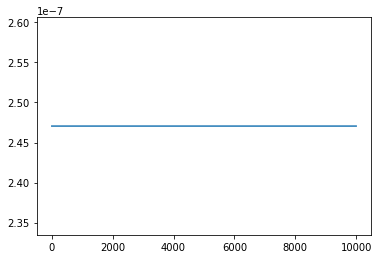

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
learning_rates = [LRScheduler(D_MODEL, WARMUP_STEPS, LEARNING_RATE).lr()
                  for _ in range(WARMUP_STEPS+2000)]
plt.plot(learning_rates)

In [33]:
from model import Transformer
model = Transformer(
    n_heads=N_HEADS,
    encoder_layers=N_LAYERS,
    decoder_layers=N_LAYERS,
    d_model=D_MODEL,
    vocab_size=VOCAB_SIZE,
    sequence_len=SENTENCE_LEN,
    dropout=DROPOUT,
    output_activation=OUTPUT_ACTIVATION)

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
encoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 512)     10240000    encoder_input[0][0]              
                                                                 decoder_input[0][0]              
__________________________________________________________________________________________________
positional_encoding_1 (Position (None, 200, 512)     0           embedding[0][0]                  
          

In [35]:
TARGET_PLACEHOLDER = tf.placeholder(dtype='int32', shape=(None, SENTENCE_LEN))
model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER,
    metrics=METRICS,
    target_tensors=[TARGET_PLACEHOLDER])

In [36]:
# print loss values for reference
def display_loss_reference():
    format_ = 'perplexity: %20s\tentropy: %20s'
    upper_limit = np.log(VOCAB_SIZE)
    print(format_ % (np.exp(upper_limit), upper_limit))
    for i in reversed(range(int(np.floor(upper_limit))+1)):
        print(format_ % (np.exp(i), i))
display_loss_reference()

perplexity:    19999.99999999998	entropy:    9.903487552536127
perplexity:    8103.083927575384	entropy:                    9
perplexity:   2980.9579870417283	entropy:                    8
perplexity:   1096.6331584284585	entropy:                    7
perplexity:    403.4287934927351	entropy:                    6
perplexity:    148.4131591025766	entropy:                    5
perplexity:   54.598150033144236	entropy:                    4
perplexity:   20.085536923187668	entropy:                    3
perplexity:     7.38905609893065	entropy:                    2
perplexity:    2.718281828459045	entropy:                    1
perplexity:                  1.0	entropy:                    0


In [37]:
model.fit_generator(
    Xy_train,
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    epochs=N_EPOCHS,
    validation_data=Xy_test,
    validation_steps=TEST_STEPS_PER_EPOCH,
    callbacks=CALLBACKS)

Epoch 1/1000
 101/7782 [..............................] - ETA: 1:55:45 - loss: 20059.7474 - sparse_categorical_crossentropy: 9.9053

KeyboardInterrupt: 